# ACCIONES

In [ ]:
# ================================================
# Pair Trading en Colab
# Fuente de datos: Stooq (CSV HTTP)
# ================================================

import io
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Intentar usar statsmodels (si no está, seguimos sin Engle–Granger)
try:
    import statsmodels.api as sm
    from statsmodels.tsa.stattools import coint
    HAS_SM = True
except Exception:
    HAS_SM = False
    sm = None

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4.5)
plt.rcParams["axes.grid"] = True
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

In [ ]:
# ------------------------------
# 1) Loader robusto desde Stooq
# ------------------------------
def stooq_url(ticker: str, interval: str = "d") -> str:
    """
    Construye la URL CSV de Stooq para un 'ticker' (ej. 'aapl', 'msft').
    interval: 'd' diario, 'w' semanal, 'm' mensual.
    """
    # Stooq usa minúsculas; tickers USA típicos: AAPL -> aapl
    t = ticker.strip().lower()
    return f"https://stooq.com/q/d/l/?s={t}&i={interval}"

def fetch_stooq_series(ticker: str, start=None, end=None, tries: int = 3, pause: float = 1.5) -> pd.Series:
    """
    Descarga Close diario de un ticker desde Stooq, con reintentos.
    Devuelve una Serie indexada por fecha (datetime) con nombre = ticker en MAYÚSCULA.
    """
    last_err = None
    url = stooq_url(ticker, "d")
    for k in range(tries):
        try:
            s = pd.read_csv(url)
            # Estructura esperada: Date,Open,High,Low,Close,Volume
            if "Date" in s.columns and "Close" in s.columns:
                s["Date"] = pd.to_datetime(s["Date"], errors="coerce", utc=False)
                s = s.dropna(subset=["Date"]).sort_values("Date")
                s = s.set_index("Date")["Close"].astype(float)
                if start is not None:
                    s = s[s.index >= pd.to_datetime(start)]
                if end is not None:
                    s = s[s.index <= pd.to_datetime(end)]
                s.name = ticker.upper()
                if not s.empty:
                    return s
        except Exception as e:
            last_err = e
        time.sleep(pause * (k + 1))
    raise RuntimeError(f"Stooq fallo para {ticker}. Último error: {last_err}")

def load_prices_stooq(tickers, start=None, end=None) -> pd.DataFrame:
    """
    Descarga 'Close' para varios tickers desde Stooq y devuelve
    un DataFrame (columnas = tickers en MAYÚSCULA).
    """
    series = []
    for t in tickers:
        s = fetch_stooq_series(t, start=start, end=end)
        series.append(s)
    df = pd.concat(series, axis=1)
    # Stooq a veces tiene huecos no simultáneos: forward-fill y limpiar faltantes iniciales
    df = df.ffill().dropna(how="any")
    return df

# -----------------------------------
# 2) Utilidades: regresión y z-score
# -----------------------------------
def regress_y_on_x(y: pd.Series, x: pd.Series):
    """
    Regresión OLS: y ~ const + beta*x. Requiere statsmodels.
    Si no hay statsmodels, usa una beta simple vía cov/var (sin intercepto).
    """
    if HAS_SM:
        X = sm.add_constant(x)
        res = sm.OLS(y, X, missing="drop").fit()
        const = float(res.params.get("const", 0.0))
        beta = float(res.params.get(x.name, 1.0))
        return const, beta
    else:
        # Fallback sencillo: beta = cov(y,x)/var(x); const = y_mean - beta*x_mean
        cov = np.cov(x.values, y.values)[0,1]
        var = np.var(x.values)
        beta = cov / var if var > 0 else 1.0
        const = float(y.mean() - beta * x.mean())
        return const, beta

def build_spread(y: pd.Series, x: pd.Series) -> pd.Series:
    """
    Spread = y - (const + beta*x). Devuelve Serie 'spread'.
    """
    const, beta = regress_y_on_x(y, x)
    spread = y - (const + beta * x)
    spread.name = f"{y.name} - (c+β·{x.name})"
    return spread

def zscore(series: pd.Series, win: int = 60) -> pd.Series:
    m = series.rolling(win, min_periods=max(10, win//3)).mean()
    s = series.rolling(win, min_periods=max(10, win//3)).std()
    z = (series - m) / s
    z.name = "zscore"
    return z

# --------------------------------------------
# 3) Señales y Backtest T+1 con costos y flips
# --------------------------------------------
def signal_from_z(z: pd.Series, z_in=2.0, z_out=0.5) -> pd.Series:
    """
    Regla:
      - Si está flat y z > +z_in -> SHORT spread (-1)
      - Si está flat y z < -z_in -> LONG  spread (+1)
      - Si está en posición y |z| < z_out -> FLAT (0)
    """
    pos = np.zeros(len(z), dtype=int)
    for i in range(1, len(z)):
        p = pos[i-1]
        zi = z.iloc[i]
        if p == 0:
            if zi >  z_in:  p = -1
            if zi < -z_in:  p = +1
        else:
            if abs(zi) < z_out:
                p = 0
        pos[i] = p
    return pd.Series(pos, index=z.index, name="position")

def pnl_from_spread(spread: pd.Series, position: pd.Series,
                    cost_bps_per_leg: float = 5.0, legs: int = 2) -> pd.DataFrame:
    """
    Backtest con ejecución T+1:
      - dS = spread.diff() (cambio bruto del spread)
      - position_eff = position.shift(1)
      - pnl_raw = position_eff * dS
      - turns = |Δ position_eff| (flip +1→-1 cuenta 2)
      - costs = turns * (cost_bps_per_leg/1e4) * legs
    Retorna DataFrame con pnl diario y acumulado.
    """
    dS = spread.diff()
    pos_eff = position.shift(1).fillna(0).astype(int)
    pnl_raw = pos_eff * dS

    turns = pos_eff.diff().abs().fillna(0)  # +1↔-1 = 2
    cost_per_turn = (cost_bps_per_leg / 1e4) * legs
    costs = turns * cost_per_turn

    pnl_net = pnl_raw - costs
    out = pd.DataFrame({
        "spread": spread,
        "dS": dS,
        "position": position,
        "position_eff": pos_eff,
        "turns": turns,
        "costs": costs,
        "pnl_raw": pnl_raw,
        "pnl_net": pnl_net,
        "pnl_cum": pnl_net.cumsum()
    })
    return out

  #HASTA AQUI TERMINE CLASE 5.

In [ ]:
# -------------------------
# 4) Parámetros del ejemplo
# -------------------------
START = "2018-05-21"
END   = None           # hasta hoy
WIN_Z = 60
Z_IN, Z_OUT = 2.0, 0.5
COST_BPS = 5.0         # 5 bps por cambio de posición y por pierna
PAIR = ("JPM.US", "BAC.US")  # cambia si quieres: ("KO","PEP"), ("XOM","CVX"), ("JPM","BAC"), ("NVDA","AMD")

In [ ]:
# -------------------------
# 5) Descarga y Backtest
# -------------------------
tickers = list(PAIR)
prices = load_prices_stooq(tickers, start=START, end=END)

# Serie X=primero, Y=segundo (y ~ c + β x)
x_tkr, y_tkr = tickers[0], tickers[1]
x, y = prices[x_tkr], prices[y_tkr]

# Engle–Granger (si statsmodels disponible)
if HAS_SM:
    score, pvalue, _ = coint(y, x)
    print(f"P-valor cointegración Engle–Granger ({y_tkr} vs {x_tkr}): {pvalue:.4f}")
else:
    print("statsmodels no disponible: se omite test de cointegración (el backtest continúa).")

# Spread, z-score, señales y PnL T+1
spread = build_spread(y, x)              # y - (c + β x)
z = zscore(spread, WIN_Z)
position = signal_from_z(z, Z_IN, Z_OUT)
bt = pnl_from_spread(spread, position, cost_bps_per_leg=COST_BPS, legs=2)

P-valor cointegración Engle–Granger (BAC.US vs JPM.US): 0.4357


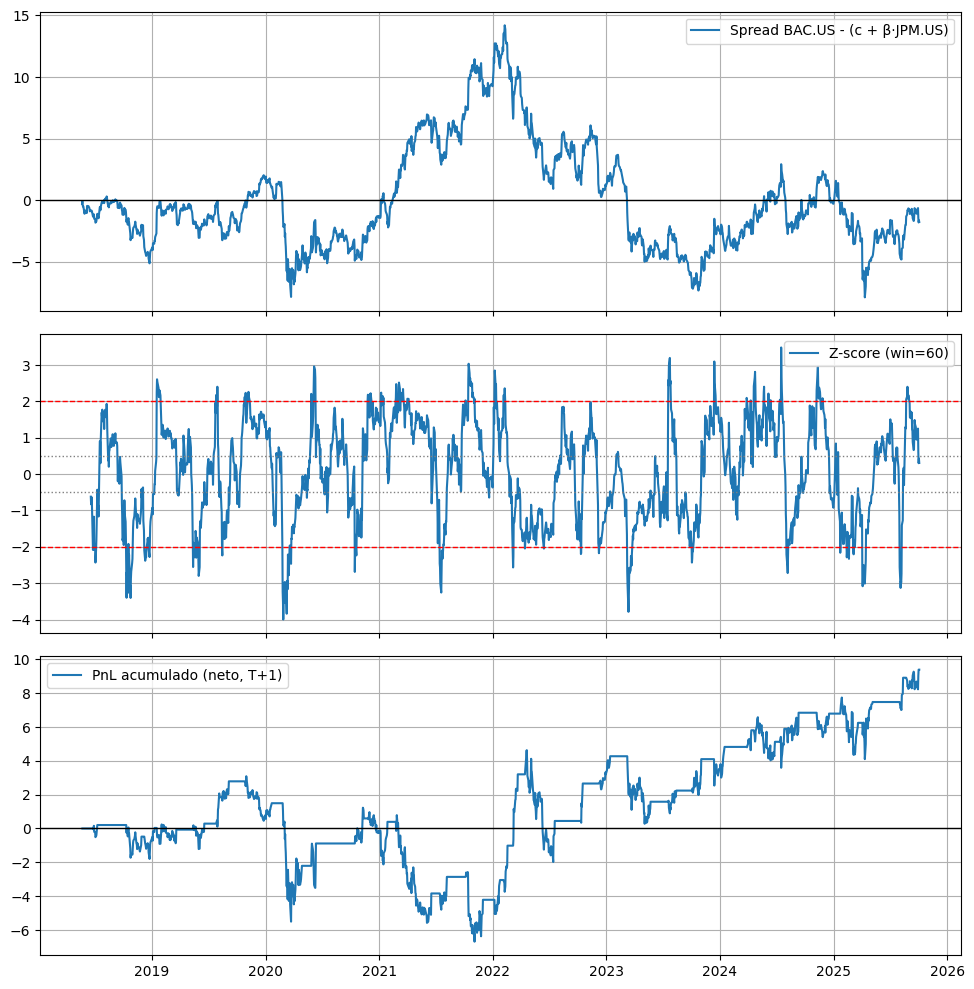

   pnl_total  pnl_ann(≈)  vol_ann(≈)  turns  days_long  days_short  days_flat
0   9.385327    1.276364    4.847972     68        457         458        939


,spread,dS,position,position_eff,turns,costs,pnl_net,pnl_cum
Date,,,,,,,,
2025-09-18,-0.639584,0.558173,-1,-1,0.000000,0.000000,-0.558173,8.228898
2025-09-19,-0.699539,-0.059954,-1,-1,0.000000,0.000000,0.059954,8.288852
2025-09-22,-0.757866,-0.058327,-1,-1,0.000000,0.000000,0.058327,8.347179
2025-09-23,-1.012696,-0.254830,-1,-1,0.000000,0.000000,0.254830,8.602009
2025-09-24,-1.091643,-0.078948,-1,-1,0.000000,0.000000,0.078948,8.680957
2025-09-25,-0.945126,0.146517,-1,-1,0.000000,0.000000,-0.146517,8.534440
2025-09-26,-0.888146,0.056980,-1,-1,0.000000,0.000000,-0.056980,8.477459
2025-09-29,-0.635189,0.252957,-1,-1,0.000000,0.000000,-0.252957,8.224503
2025-09-30,-1.435003,-0.799814,-1,-1,0.000000,0.000000,0.799814,9.024317


In [ ]:
# -------------------------
# 6) Gráficos y resumen
# -------------------------
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

ax[0].plot(spread.index, spread.values, label=f"Spread {y_tkr} - (c + β·{x_tkr})")
ax[0].axhline(0, color="k", lw=1)
ax[0].legend()

ax[1].plot(z.index, z.values, label=f"Z-score (win={WIN_Z})")
ax[1].axhline( Z_IN,  color="r",  ls="--", lw=1)
ax[1].axhline(-Z_IN,  color="r",  ls="--", lw=1)
ax[1].axhline( Z_OUT, color="grey", ls=":",  lw=1)
ax[1].axhline(-Z_OUT, color="grey", ls=":",  lw=1)
ax[1].legend()

ax[2].plot(bt.index, bt["pnl_cum"], label="PnL acumulado (neto, T+1)")
ax[2].axhline(0, color="k", lw=1)
ax[2].legend()

plt.tight_layout()
plt.show()

resumen = pd.DataFrame({
    "pnl_total": [bt["pnl_net"].sum()],
    "pnl_ann(≈)": [bt["pnl_net"].mean() * 252],
    "vol_ann(≈)": [bt["pnl_net"].std() * np.sqrt(252)],
    "turns": [int(bt["turns"].sum())],
    "days_long": [int((bt["position_eff"]== 1).sum())],
    "days_short":[int((bt["position_eff"]==-1).sum())],
    "days_flat": [int((bt["position_eff"]== 0).sum())],
})
print(resumen)

# Últimas filas para inspección
display(bt[["spread","dS","position","position_eff","turns","costs","pnl_net","pnl_cum"]].tail(12))

# RIESGO

In [ ]:
# =========================
# CONFIGURACIÓN Y UTILIDADES
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Si NO tienes esta función en tu notebook, descomenta e implementa tu fetch:
# from your_module import load_prices_stooq
# def fetch_stooq_series(t, start=None, end=None):
#     import pandas_datareader.data as web
#     s = web.DataReader(t, "stooq", start=start, end=end)["Close"].rename(t.upper())
#     return s.sort_index()
#
# def load_prices_stooq(tickers, start=None, end=None) -> pd.DataFrame:
#     series = []
#     for t in tickers:
#         s = fetch_stooq_series(t, start=start, end=end)
#         series.append(s)
#     df = pd.concat(series, axis=1).ffill().dropna(how="any")
#     df.columns = [c.upper() for c in df.columns]
#     return df

def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    rets = np.log(prices / prices.shift(1)).dropna(how="all")
    return rets

def max_drawdown(cum_returns: pd.Series) -> float:
    # cum_returns: índice de valor (1 -> 1.01 -> etc.). Si tienes PnL, conviértelo a índice antes.
    running_max = cum_returns.cummax()
    dd = cum_returns / running_max - 1.0
    return dd.min()

def value_at_risk(returns: pd.Series, alpha: float = 0.05, method: str = "historical"):
    r = returns.dropna()
    if method == "historical":
        return np.quantile(r, alpha)
    elif method == "gaussian":
        mu, sigma = r.mean(), r.std(ddof=1)
        from scipy.stats import norm
        return mu + sigma * norm.ppf(alpha)
    else:
        raise ValueError("method debe ser 'historical' o 'gaussian'.")

def expected_shortfall(returns: pd.Series, alpha: float = 0.05):
    r = returns.dropna()
    var = np.quantile(r, alpha)
    tail = r[r <= var]
    if len(tail) == 0:
        return np.nan
    return tail.mean()

def summarize_risk(returns: pd.Series, name: str, freq: int = 252) -> dict:
    """Resumen de riesgo-retorno para una serie de retornos diarios."""
    mu = returns.mean()
    sd = returns.std(ddof=1)
    ann_mu = mu * freq
    ann_sd = sd * np.sqrt(freq)
    sharpe = np.nan if ann_sd == 0 else ann_mu / ann_sd
    mdd = max_drawdown((1 + returns).cumprod())
    var_95 = value_at_risk(returns, alpha=0.05, method="historical")
    es_95 = expected_shortfall(returns, alpha=0.05)
    return {
        "E[R]_ann": ann_mu,
        "Vol_ann": ann_sd,
        "Sharpe": sharpe,
        "Skew": skew(returns.dropna(), bias=False),
        "Kurtosis_exceso": kurtosis(returns.dropna(), fisher=True, bias=False),
        "VaR_5%": var_95,
        "ES_5%": es_95,
        "MaxDD": mdd,
        "N": returns.dropna().shape[0],
        "name": name,
    }


In [ ]:
# 1) DESCARGA DE DATOS

# Ajusta el universo. Ejemplo con Stooq (sufijo .US para acciones USA):
tickers = [
    "AAPL.US", "MSFT.US", "NVDA.US", "META.US", "AMZN.US",  # tech/alta vol (suele)
    "PG.US", "KO.US", "PEP.US", "WMT.US", "JNJ.US",         # defensivas/menor vol (suele)
    "XOM.US", "CVX.US", "JPM.US", "BAC.US", "UNH.US"
]

# Define tu ventana de estimación de volatilidad
VOL_WINDOW = 60  # días

prices = load_prices_stooq(tickers)
returns = compute_log_returns(prices)
returns.tail()

,AAPL.US,MSFT.US,NVDA.US,META.US,AMZN.US,PG.US,KO.US,PEP.US,WMT.US,JNJ.US,XOM.US,CVX.US,JPM.US,BAC.US,UNH.US
Date,,,,,,,,,,,,,,,
2025-09-29,-0.004040,0.006121,0.020332,-0.000471,0.010816,0.006731,0.005618,-0.001924,-0.000776,0.010572,-0.025926,-0.025676,-0.001171,0.004014,0.003192
2025-09-30,0.000786,0.006489,0.025678,-0.012208,-0.011772,0.000781,0.004231,0.001924,-0.000194,0.020707,-0.012953,-0.005202,-0.000824,-0.015960,0.000348
2025-10-01,0.003215,0.003392,0.003531,-0.023477,0.004816,-0.003064,0.006912,0.019043,-0.010731,0.003392,-0.006763,-0.004583,-0.015077,-0.017796,0.008651
2025-10-02,0.006555,-0.007668,0.008774,0.013445,0.008035,-0.007404,-0.010235,-0.005815,-0.002553,-0.000376,-0.006270,-0.007858,-0.010222,-0.003954,0.015441
2025-10-03,0.003568,0.003117,-0.006746,-0.022942,-0.013125,0.001446,0.008286,-0.002322,0.003632,0.014201,0.017547,0.001173,0.008031,0.003165,0.018154


In [ ]:
# 2) CLASIFICAR POR VOLATILIDAD (ROLLING)

# Calculamos volatilidad rolling por activo, y seleccionamos LOW-VOL y HIGH-VOL por fecha
rolling_vol = returns.rolling(VOL_WINDOW).std()

# Elige tamaño del grupo (p.ej., 5 activos low-vol y 5 high-vol)
GROUP_SIZE = 5

def make_long_short_baskets(returns_df: pd.DataFrame, rolling_vol_df: pd.DataFrame, group_size: int = 5):
    # Para cada fecha, elegimos los tickers con menor vol (LOW) y mayor vol (HIGH)
    low_idx = {}
    high_idx = {}
    for dt, row in rolling_vol_df.iterrows():
        row = row.dropna()
        if row.shape[0] < group_size * 2:
            continue
        sort_idx = row.sort_values()
        low_idx[dt] = list(sort_idx.index[:group_size])
        high_idx[dt] = list(sort_idx.index[-group_size:])
    low_idx = pd.Series(low_idx)
    high_idx = pd.Series(high_idx)
    # Alinear a intersección de fechas
    ixs = low_idx.index.intersection(high_idx.index).intersection(returns_df.index)
    low_idx = low_idx.loc[ixs]
    high_idx = high_idx.loc[ixs]
    # Construir retornos de cada cesta (equal-weight, rebalanceo diario)
    low_ret = []
    high_ret = []
    for dt in ixs:
        low_tks = low_idx.loc[dt]
        high_tks = high_idx.loc[dt]
        low_ret.append(returns_df.loc[dt, low_tks].mean())
        high_ret.append(returns_df.loc[dt, high_tks].mean())
    low_series = pd.Series(low_ret, index=ixs, name="LOW_VOL")
    high_series = pd.Series(high_ret, index=ixs, name="HIGH_VOL")
    return low_series, high_series, low_idx, high_idx

low_ret, high_ret, low_sets, high_sets = make_long_short_baskets(returns, rolling_vol, GROUP_SIZE)

low_ret.head(), high_ret.head()


(2012-08-14    0.003984
 2012-08-15    0.000982
 2012-08-16   -0.002016
 2012-08-17   -0.002240
 2012-08-20   -0.000629
 Name: LOW_VOL, dtype: float64,
 2012-08-14   -0.011831
 2012-08-15    0.012136
 2012-08-16   -0.003767
 2012-08-17   -0.009363
 2012-08-20    0.014945
 Name: HIGH_VOL, dtype: float64)

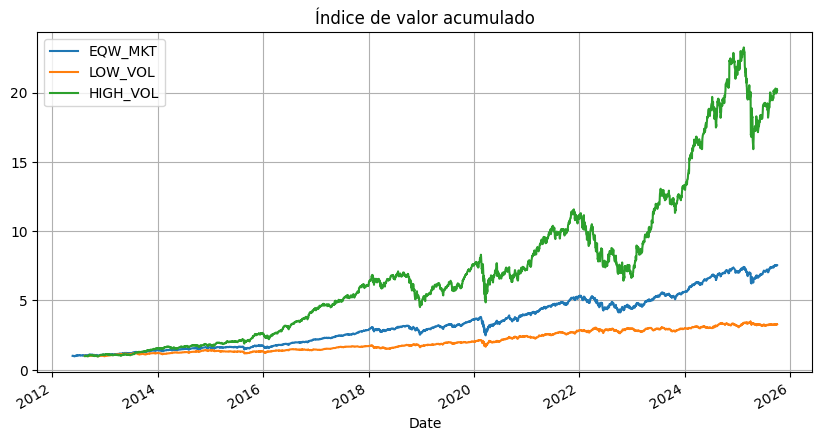

In [ ]:
# =========================
# 3) PORTAFOLIOS Y BENCHMARK
# =========================
# Portafolio LOW-VOL, HIGH-VOL y LONG-ONLY mercado (equal-weight fijo sobre universo)
eqw_market = returns.mean(axis=1).rename("EQW_MKT")

# Índices de valor acumulado (1 = inicio)
def to_index(r: pd.Series) -> pd.Series:
    return (1 + r.fillna(0)).cumprod()

idx_low  = to_index(low_ret)
idx_high = to_index(high_ret)
idx_mkt  = to_index(eqw_market)

# Quick plot
ax = idx_mkt.plot(label="EQW_MKT")
idx_low.plot(ax=ax, label="LOW_VOL")
idx_high.plot(ax=ax, label="HIGH_VOL")
plt.legend()
plt.title("Índice de valor acumulado")
plt.show()


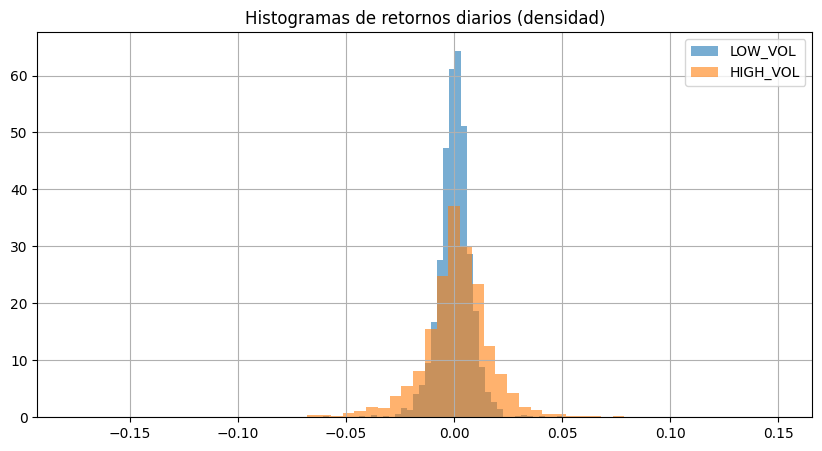

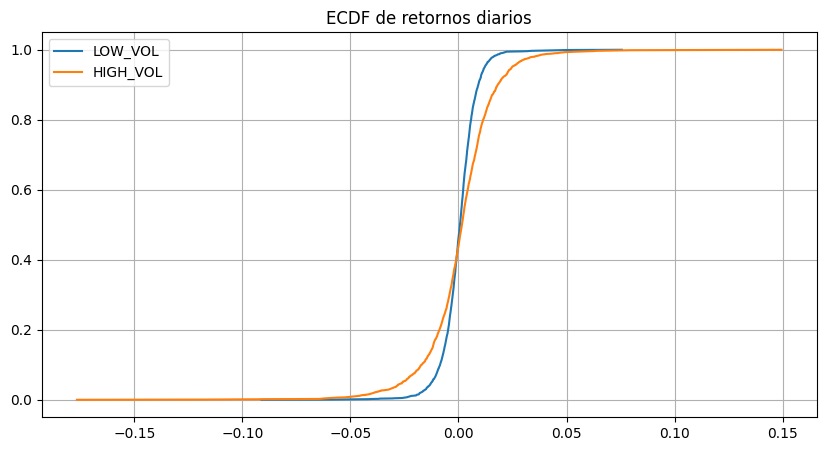

/tmp/ipython-input-3661091966.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([low_ret.dropna(), high_ret.dropna()], labels=["LOW_VOL","HIGH_VOL"])


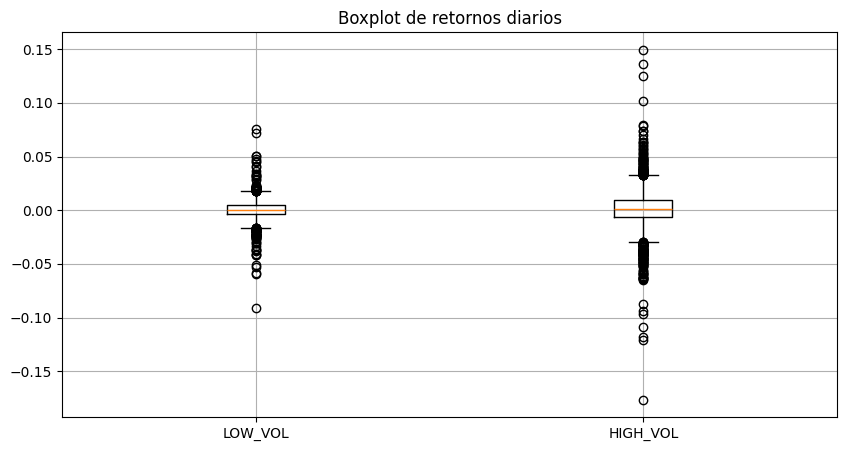

In [ ]:
# =========================
# 4) DISTRIBUCIONES Y COLAS (RISK LENS)
# =========================
# Histogramas y curvas empíricas (ECDF) para comparar forma de la distribución
def plot_hist(a: pd.Series, b: pd.Series, labels=("A","B"), bins=60):
    plt.hist(a.dropna(), bins=bins, alpha=0.6, density=True, label=labels[0])
    plt.hist(b.dropna(), bins=bins, alpha=0.6, density=True, label=labels[1])
    plt.title("Histogramas de retornos diarios (densidad)")
    plt.legend()
    plt.show()

def plot_ecdf(series: pd.Series, label: str):
    x = np.sort(series.dropna().values)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, label=label)

# Comparar LOW vs HIGH
plot_hist(low_ret, high_ret, labels=("LOW_VOL", "HIGH_VOL"))

plt.figure()
plot_ecdf(low_ret, "LOW_VOL")
plot_ecdf(high_ret, "HIGH_VOL")
plt.title("ECDF de retornos diarios")
plt.legend()
plt.show()

# Boxplots
plt.boxplot([low_ret.dropna(), high_ret.dropna()], labels=["LOW_VOL","HIGH_VOL"])
plt.title("Boxplot de retornos diarios")
plt.show()


In [ ]:
# =========================
# 5) MÉTRICAS DE RIESGO-RETORNO
# =========================
rows = []
rows.append(summarize_risk(low_ret,  "LOW_VOL"))
rows.append(summarize_risk(high_ret, "HIGH_VOL"))
rows.append(summarize_risk(eqw_market, "EQW_MKT"))

summary = pd.DataFrame(rows).set_index("name")
summary = summary[["E[R]_ann","Vol_ann","Sharpe","Skew","Kurtosis_exceso","VaR_5%","ES_5%","MaxDD","N"]]
summary.sort_values("Vol_ann", inplace=True)
summary.style.format({
    "E[R]_ann": "{:.2%}", "Vol_ann": "{:.2%}", "Sharpe": "{:.2f}",
    "Skew": "{:.2f}", "Kurtosis_exceso": "{:.2f}",
    "VaR_5%": "{:.2%}", "ES_5%": "{:.2%}", "MaxDD": "{:.2%}"
})


,E[R]_ann,Vol_ann,Sharpe,Skew,Kurtosis_exceso,VaR_5%,ES_5%,MaxDD,N
name,,,,,,,,,
LOW_VOL,9.94%,13.35%,0.74,-0.30,12.72,-1.23%,-1.93%,-22.40%,3304
EQW_MKT,16.55%,16.79%,0.99,-0.59,16.96,-1.51%,-2.55%,-35.01%,3363
HIGH_VOL,26.63%,27.14%,0.98,-0.38,11.47,-2.58%,-4.09%,-44.46%,3304


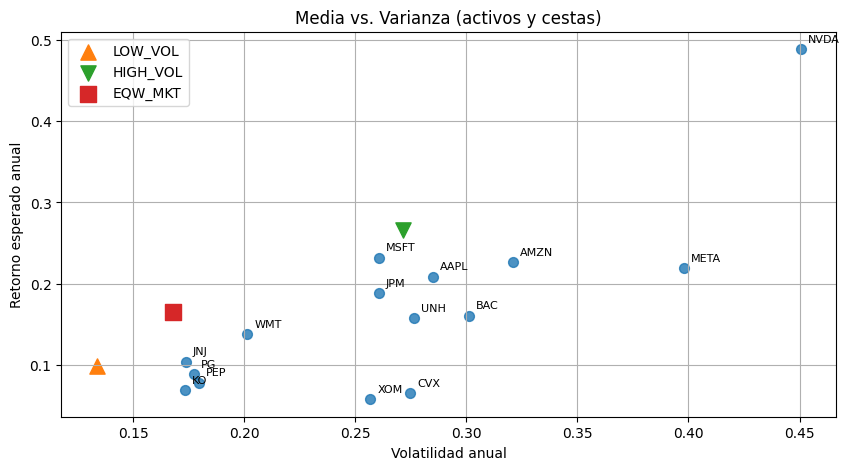

In [ ]:
# =========================
# 6) FRONTERA MEDIA-VARIANZA (SIMPLE SNAPSHOT)
# =========================
# Mapa dispersión media vs. vol de cada activo individual (anualizado)
mu_ann = returns.mean() * 252
sd_ann = returns.std() * np.sqrt(252)

plt.scatter(sd_ann, mu_ann, s=50, alpha=0.8)
for t in returns.columns:
    plt.annotate(t.replace(".US",""), (sd_ann[t], mu_ann[t]), xytext=(5, 5), textcoords="offset points", fontsize=8)

# Añadimos las cestas
plt.scatter(summary.loc["LOW_VOL","Vol_ann"], summary.loc["LOW_VOL","E[R]_ann"], marker="^", s=120, label="LOW_VOL")
plt.scatter(summary.loc["HIGH_VOL","Vol_ann"], summary.loc["HIGH_VOL","E[R]_ann"], marker="v", s=120, label="HIGH_VOL")
plt.scatter(summary.loc["EQW_MKT","Vol_ann"], summary.loc["EQW_MKT","E[R]_ann"], marker="s", s=120, label="EQW_MKT")
plt.xlabel("Volatilidad anual")
plt.ylabel("Retorno esperado anual")
plt.title("Media vs. Varianza (activos y cestas)")
plt.legend()
plt.show()
